# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [ ]:
from random import seed as random_seed
random_seed(50)
from numpy.random import seed as np_random_seed
np_random_seed(50)

tf.random.set_seed(50)

In [1]:
import os

os.sys.path.append(r'/docker_mnt/data5/jin/jin/python/')

os.sys.path

['/sgcwhb/Malocclusion/regression/bom',
 '/root/miniconda3/lib/python37.zip',
 '/root/miniconda3/lib/python3.7',
 '/root/miniconda3/lib/python3.7/lib-dynload',
 '',
 '/root/miniconda3/lib/python3.7/site-packages',
 '/root/miniconda3/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython',
 '/docker_mnt/data5/jin/jin/python/']

In [2]:
import tensorflow as tf

In [3]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 281691482775727019,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4127010532082373261
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48242412749
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16221506622700198845
 physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:61:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8993159984741629299
 physical_device_desc: "device: XLA_GPU device"]

In [4]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

env: PYTHONHASHSEED=0


## Paths
---

In [19]:
so_type = 'so_rl'

input_path_root = r'../../data/input_data/'

# <model 저장>
# output_path_root = r'../results/'
output_path_root = r'../../results/0.2_prototype_rg_multiO3_so_img/'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

try:
    os.makedirs(output_path_weight) 
    
except FileExistsError as err:      
    print(err)
# else:
#     print(output_path)
#     print(output_path_weight)

In [20]:
input_path_root

'../../data/input_data/'

In [21]:
output_path_root

'../../results/0.2_prototype_rg_multiO3_so_img/'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [22]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y, y_distance):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]]) # Right side,Left side !!!
        
        y_r_test= to_categorical(y[:,0], num_classes=3)
        y_l_test= to_categorical(y[:,1], num_classes=3)
        
        y = np.concatenate([y[:, 0], y[:, 1]])
        y_onehot=np.concatenate((y_r_test,y_l_test),axis=0)
        
        y_distance = np.concatenate([y_distance[:, 0], y_distance[:, 1]])
    
    return x, y, y_onehot, y_distance

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [23]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_Diorco_label.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)
y_distance = y_distance.astype(np.float32)

x = x / 127.5
x = x - 1.

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

In [10]:
#---------onehot function test------------------
x_tt, y_tt, y_onehot_tt,y_distance_tt=generate_data_by_patient(x,y,y_distance)

y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]

y_onehot_tt_r=list(y_onehot_tt_r)
y_onehot_tt_l=list(y_onehot_tt_l)

print("regression:",y_tt.min(),"||",y_tt.max())
print("classification:",y_onehot_tt.min(),"||",y_onehot_tt.max())
print("distance:",y_distance_tt.min(),"||",y_distance_tt.max())

label_df["one-hot-r"]=y_onehot_tt_r
label_df["one-hot-l"]=y_onehot_tt_l
label_df

#---------------------------------------------

regression: -1.0 || 1.0
classification: 0.0 || 1.0
distance: -24.48 || 25.12


,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


float32 (2009, 480, 784, 6)
float32 (2009, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     2009 non-null   object 
 1   tx_phase       2009 non-null   object 
 2   angle_class_r  2009 non-null   int64  
 3   angle_class_l  2009 non-null   int64  
 4   distance(r)    2009 non-null   float64
 5   distance(l)    2009 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 94.3+ KB


None

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
1,QH0026,Post-Tx,0,1,1.22,2.10
2,QH0041,Pre-Tx,1,0,2.57,0.88
3,QH0041,Post-Tx,1,0,3.58,1.05
4,QH0044,Pre-Tx,1,1,6.94,4.63
...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83
2006,QH1072,Post-Tx,1,1,7.41,5.26
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55


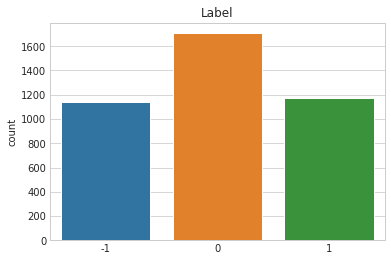

In [14]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [11]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])


print("calss -1:",len(cnt[cnt==-1]))
print("calss 0:",len(cnt[cnt==0]))
print("calss 1:",len(cnt[cnt==1]))

calss -1: 1136
calss 0: 1707
calss 1: 1175


## Model
---

In [24]:
def build_model():
    base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=(None, None, 3))

#     base_model.trainable = False

#     for layer in base_model.layers:
#         layer.trainable = False

    # base_model.summary()

    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(256, activation='relu', name='dense')(x)
    x = layers.Dropout(0.2, name='dropout')(x)
    
    regression_prediction=layers.Dense(1, name='regression_prediction')(x)
    one_hot_prediction=layers.Dense(3, activation='softmax', name='classification')(regression_prediction)
    distance_prediction=layers.Dense(1, name='distance_prediction')(x)

    
    model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
#     model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
    
    return model

In [14]:
model=build_model()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
# model.compile(optimizer=optimizers.Adam(lr=1e-3),
#                       loss=["mae","categorical_crossentropy","mae"],
#                       metrics=["acc","mae"])
model.compile(optimizer=optimizers.Adam(lr=1e-3),
              loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
              loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':0.1},
              metrics=["acc","mae"])

## Train the Model
---

In [25]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])): #left???
    
    if kfold_idx==0:
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        # 1. Data
        # ----------------------------------------

    #------DEBUG--------:
    #     print(test_idxs)     
    #     print(np.unique(y[test_idxs, 0], return_counts=True))
    #-------------------   

        x_train = x[train_idxs]
        y_train = y[train_idxs]
        y_distance_train =y_distance[train_idxs]
    #     label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, y_distance_train, y_distance_val = train_test_split(x_train, y_train, y_distance_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0])

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_distance_test =y_distance[test_idxs]
    #     label_df_test = label_df.iloc[test_idxs]

        #distance 누락!
        x_train, y_train,y_train_onehot, y_train_distance = generate_data_by_patient(x_train, y_train, y_distance_train)
        x_val, y_val, y_val_onehot, y_val_distance = generate_data_by_patient(x_val, y_val, y_distance_val)
        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test, y_distance_test)

        weight_for_m1 = (1 / len(y_train[y_train==-1]))*(len(y_train))/3.0 
        weight_for_0 = (1 / len(y_train[y_train==0]))*(len(y_train))/3.0 
        weight_for_1 = (1 / len(y_train[y_train==1]))*(len(y_train))/3.0

        class_weight=[weight_for_m1,weight_for_0,weight_for_1]

    #------DEBUG--------:
    #     print(len(y_train))
    #     print("class -1;",len(y_train[y_train==-1]))
    #     print("class 0;",len(y_train[y_train==0]))
    #     print("class 1;",len(y_train[y_train==1]))

    #     print("-------------")
    #     print(weight_for_m1)
    #     print(weight_for_0)
    #     print(weight_for_1)

    #------------------- 


        # DEBUG:
    #     plt.figure(figsize=(8, 6))

    #     plt.subplot(121)
    #     data_idx1 = 1
    #     plt.title(info_train.iloc[data_idx1, 0])
    #     plt.imshow((x_train[data_idx1] + 1) / 2)
    #     plt.xlabel(f'Label: {y_train[data_idx1]}')

    #     plt.subplot(122)
    #     data_idx2 = data_idx1 + len(x_train) // 4
    #     plt.title(info_train.iloc[data_idx2, 0])
    #     plt.imshow((x_train[data_idx2] + 1) / 2)
    #     plt.xlabel(f'Label: {y_train[data_idx2]}')

    #     plt.show()
    #     print(x_train.dtype, x_train.shape)
    #     print(y_train.dtype, y_train.shape)
    #     print()
    #     print(x_val.dtype, x_val.shape)
    #     print(y_val.dtype, y_val.shape)
    #     print()
    #     print(x_test.dtype, x_test.shape)
    #     print(y_test.dtype, y_test.shape)

        # 2. Paths
        # ----------------------------------------

        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)

        # 3. Build a Model.
        # ----------------------------------------

        if kfold_idx == 0:
            model = build_model()

            model.compile(optimizer=optimizers.Adam(lr=1e-3),
                          loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
                          loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':0.2},
                          metrics=["acc","mae"])

            model.save(os.path.join(output_path, r'model.hdf5'))

            # model.summary()
        else:
            model = models.load_model(os.path.join(output_path, r'model.hdf5'))

        # 4. Train the Model.
        # ----------------------------------------

        # Callbacks
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)


        # Training batch size 16 -> 8
        model.fit(x_train,{'regression_prediction':y_train, 'classification':y_train_onehot,'distance_prediction':y_train_distance},
                  batch_size=8,
                  epochs=50,
                  validation_data=(x_val, {'regression_prediction':y_val,'classification':y_val_onehot,'distance_prediction':y_val_distance}),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=0,
                  class_weight=[class_weight,class_weight,class_weight],
                  verbose=1)

        K.clear_session()
        del model

K-Fold CV: 01/10
Train on 2892 samples, validate on 724 samples
Epoch 1/50
2892/2892 [==============================] - 212s 73ms/sample - loss: 2.1200 - regression_prediction_loss: 0.6122 - classification_loss: 1.0963 - distance_prediction_loss: 2.0601 - regression_prediction_acc: 0.4212 - regression_prediction_mae: 0.6120 - classification_acc: 0.4101 - classification_mae: 0.4427 - distance_prediction_acc: 0.0024 - distance_prediction_mae: 2.0589 - val_loss: 2.0303 - val_regression_prediction_loss: 0.5724 - val_classification_loss: 1.0880 - val_distance_prediction_loss: 1.8591 - val_regression_prediction_acc: 0.4282 - val_regression_prediction_mae: 0.5715 - val_classification_acc: 0.4282 - val_classification_mae: 0.4411 - val_distance_prediction_acc: 0.0014 - val_distance_prediction_mae: 1.8552
Epoch 2/50
2892/2892 [==============================] - 189s 65ms/sample - loss: 2.0410 - regression_prediction_loss: 0.5547 - classification_loss: 1.0883 - distance_prediction_loss: 1.9918 - r

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])): #left???
    
    if kfold_idx==0:
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        # 1. Data
        # ----------------------------------------

    #------DEBUG--------:
    #     print(test_idxs)     
    #     print(np.unique(y[test_idxs, 0], return_counts=True))
    #-------------------   

        x_train = x[train_idxs]
        y_train = y[train_idxs]
        y_distance_train =y_distance[train_idxs]
    #     label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, y_distance_train, y_distance_val = train_test_split(x_train, y_train, y_distance_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0])

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_distance_test =y_distance[test_idxs]
    #     label_df_test = label_df.iloc[test_idxs]

        #distance 누락!
        x_train, y_train,y_train_onehot, y_train_distance = generate_data_by_patient(x_train, y_train, y_distance_train)
        x_val, y_val, y_val_onehot, y_val_distance = generate_data_by_patient(x_val, y_val, y_distance_val)
        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test, y_distance_test)

        weight_for_m1 = (1 / len(y_train[y_train==-1]))*(len(y_train))/3.0 
        weight_for_0 = (1 / len(y_train[y_train==0]))*(len(y_train))/3.0 
        weight_for_1 = (1 / len(y_train[y_train==1]))*(len(y_train))/3.0

        class_weight=[weight_for_m1,weight_for_0,weight_for_1]

    #------DEBUG--------:
    #     print(len(y_train))
    #     print("class -1;",len(y_train[y_train==-1]))
    #     print("class 0;",len(y_train[y_train==0]))
    #     print("class 1;",len(y_train[y_train==1]))

    #     print("-------------")
    #     print(weight_for_m1)
    #     print(weight_for_0)
    #     print(weight_for_1)

    #------------------- 


        # DEBUG:
    #     plt.figure(figsize=(8, 6))

    #     plt.subplot(121)
    #     data_idx1 = 1
    #     plt.title(info_train.iloc[data_idx1, 0])
    #     plt.imshow((x_train[data_idx1] + 1) / 2)
    #     plt.xlabel(f'Label: {y_train[data_idx1]}')

    #     plt.subplot(122)
    #     data_idx2 = data_idx1 + len(x_train) // 4
    #     plt.title(info_train.iloc[data_idx2, 0])
    #     plt.imshow((x_train[data_idx2] + 1) / 2)
    #     plt.xlabel(f'Label: {y_train[data_idx2]}')

    #     plt.show()
    #     print(x_train.dtype, x_train.shape)
    #     print(y_train.dtype, y_train.shape)
    #     print()
    #     print(x_val.dtype, x_val.shape)
    #     print(y_val.dtype, y_val.shape)
    #     print()
    #     print(x_test.dtype, x_test.shape)
    #     print(y_test.dtype, y_test.shape)

        # 2. Paths
        # ----------------------------------------

        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)

        # 3. Build a Model.
        # ----------------------------------------

        if kfold_idx == 0:
            model = build_model()

            model.compile(optimizer=optimizers.Adam(lr=1e-3),
                          loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
                          loss_weight={'regression_prediction':1,'classification':1,'distance_prediction':0.5},
                          metrics=["acc","mae"])

            model.save(os.path.join(output_path, r'model.hdf5'))

            # model.summary()
        else:
            model = models.load_model(os.path.join(output_path, r'model.hdf5'))

        # 4. Train the Model.
        # ----------------------------------------

        # Callbacks
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)


        # Training batch size 16 -> 8
        model.fit(x_train,{'regression_prediction':y_train, 'classification':y_train_onehot,'distance_prediction':y_train_distance},
                  batch_size=8,
                  epochs=50,
                  validation_data=(x_val, {'regression_prediction':y_val,'classification':y_val_onehot,'distance_prediction':y_val_distance}),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=0,
                  class_weight=[class_weight,class_weight,class_weight],
                  verbose=1)

        K.clear_session()
        del model

## Evaluation
---

In [21]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
1,QH0026,Post-Tx,0,1,1.22,2.10
2,QH0041,Pre-Tx,1,0,2.57,0.88
3,QH0041,Post-Tx,1,0,3.58,1.05
4,QH0044,Pre-Tx,1,1,6.94,4.63
...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83
2006,QH1072,Post-Tx,1,1,7.41,5.26
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55


In [22]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l)
0,QH0026,Pre-Tx,0,0,1.48,1.23
3,QH0041,Post-Tx,1,0,3.58,1.05
5,QH0044,Post-Tx,1,1,9.15,7.06
6,QH0059,Pre-Tx,0,0,1.13,0.81
7,QH0059,Post-Tx,1,-1,1.53,0.49


In [18]:
output_path

'../../results/3_prototype_rg_multiO3_so_img/so_rl'

K-Fold CV: 01/10


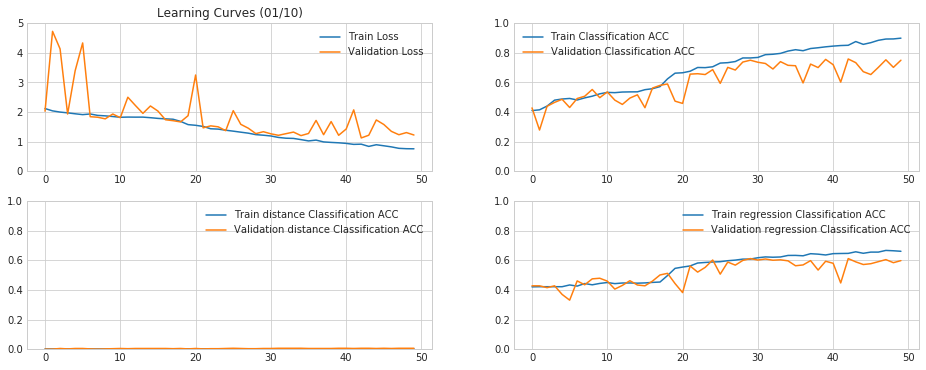

Min. validation loss epoch: 43
Max. Classification ACC epoch: 43
Max. distance validation ACC epoch: 26
Max. regression validation ACC epoch: 30


In [26]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# model_parm_name="D"+depth+"_"+dropout_rat

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    
    if kfold_idx==0:

        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        # 1. Data
        # ----------------------------------------

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_test_distance= y_distance[test_idxs]

        label_df_test = label_df.iloc[test_idxs]

        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test,y_test_distance)

        # 2. Paths
        # ----------------------------------------

    #     output_path_kfold = os.path.join(output_path, model_parm_name, f'kfold_{kfold_idx + 1:02d}/')
        output_path_kfold = os.path.join(output_path,  f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        # 3. Plot Learning Curves.
        # ----------------------------------------

        # log 저장: loss, mae, val_loss, val_mae
        log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))


        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(16, 6))

        plt.subplot(2,2,1)
        plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
        plt.plot(log_df.loss)
        plt.plot(log_df.val_loss)
        plt.ylim(0, 5)
        plt.legend(('Train Loss', 'Validation Loss'))

        plt.subplot(2,2,2)
        plt.plot(log_df.classification_acc)
        plt.plot(log_df.val_classification_acc)
        plt.ylim(0, 1)
        plt.legend(('Train Classification ACC', 'Validation Classification ACC'))

        plt.subplot(2,2,3)
        plt.plot(log_df.distance_prediction_acc)
        plt.plot(log_df.val_distance_prediction_acc)
        plt.ylim(0, 1)
        plt.legend(('Train distance Classification ACC', 'Validation distance Classification ACC'))

        plt.subplot(2,2,4)
        plt.plot(log_df.regression_prediction_acc)
        plt.plot(log_df.val_regression_prediction_acc)
        plt.ylim(0, 1)
        plt.legend(('Train regression Classification ACC', 'Validation regression Classification ACC'))

        plt.show()
        plt.style.use('seaborn-white')
        print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
        print(f'Max. Classification ACC epoch: {log_df.val_classification_acc.idxmax() + 1}')
        print(f'Max. distance validation ACC epoch: {log_df.val_distance_prediction_acc.idxmax() + 1}')
        print(f'Max. regression validation ACC epoch: {log_df.val_regression_prediction_acc.idxmax() + 1}')



        info_df = label_df.copy()

        result_info_df = info_df.iloc[test_idxs]

        inference_df = result_info_df.copy()

        # 4. Load a Model.
        # ----------------------------------------

        K.clear_session()

        #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
        model = models.load_model(os.path.join(output_path, r'model.hdf5'))
        #validation mae가 가장 적은 model weight load
        model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_loss.idxmin() + 1:08d}*.hdf5'))[0])

        # 5. Display
        # ----------------------------------------


        prediction = model.predict(x_test)

        prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
        prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left

        r = prediction_distance_r.copy()
        l = prediction_distance_l.copy()

        #-1~1사이 score
        r = np.round(r) #반올림
        r[r<-1]= -1
        r[r>1] = 1


        l = np.round(l)
        l[l<-1]= -1
        l[l>1] = 1    

    #     print(l.shape)
    #     print(r.shape)
    #     print(info_df.shape)
    #     print(result_info_df.shape)

        inference_df['prediction_class_r'] = r
        inference_df['prediction_class_l'] =l
        inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
        inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)




        inference_df.to_csv(os.path.join(output_path_kfold, r'info.csv'))
        total_info.append(inference_df)

    total_df = pd.concat(total_info)
    total_df.to_csv(os.path.join(output_path,'total.csv'))


In [27]:
log_df.val_classification_acc.max()

0.7582873

In [ ]:
total_df

In [ ]:
kfold_results_df = pd.DataFrame(metrics, columns=('test_loss', 'test_mae'))


In [28]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)


cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

[[ 59  42   2]
 [ 11 157   8]
 [  0  28  95]]

Accuracy: 0.774


In [ ]:
kfold_results_df.describe()

In [ ]:
np.sum(cm)